# Horizon 2020 NLP analysis


Where we take the H2020 corpus produced by Sahra and analyse it using different NLP modelling strategies.

**Pipeline**

````
    Load corpus
        |
        v
       Exploratory data analysis (word frequencies etc)
        |   
        ----> Train models (word embeddings) ------> Cluster words -----> Allocate projects to clusters
        |
        ----> Train models (LDA) [this might require some additional pre-processing
        
````

## Preamble

Imports and functions


In [694]:
#Magics

%matplotlib inline

#Imports

#Sahra
import pandas as pd
import string as st
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, PunktSentenceTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer, PorterStemmer

#Kostas

from itertools import product
import re
import os
import sys
import gensim
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
sys.path.append('../src/features/scripts/')
from script_train_w2v_meetup import *
sys.path.append('../src/models/scripts/')
from evaluate_gmm import *


#Paths
external_path = os.path.join(os.path.dirname(os.getcwd()),'data/external')
interim_path = os.path.join(os.path.dirname(os.getcwd()),'data/interim')
model_path = os.path.join(os.path.dirname(os.getcwd()),'models')


In [146]:
#Functions

def comp_sentence(sentence):
    '''
    Takes a sentence and pre-processes it.
    The output is the sentence as a bag of words
    
    '''
    #Remove numbers
    text_no_numbers = re.sub('|'.join([x for x in st.digits]),'',sentence)
    
    #Tokenise
    text_punctuation = tokenizer.tokenize(text_no_numbers)
    
    #Lowercase
    text_lowered = [token.lower() for token in text_punctuation]
        
    #Remove stop words, single letters
    text_stopped = [w for w in text_lowered if w not in stop_words and
                   len(w)>1]
    
    #Stem
    #text_stemmed = [stemmer.stem(w) for w in text_stopped]
    
    #Output
    return(text_stopped)

## 1. Load data

In [144]:
#These are some of the functions used in the comp_sentence (in case I need to use it later)

#Stop words to remove
stop_words = set(stopwords.words("english"))

#Lemmatise
lemmatizer = WordNetLemmatizer()

#Punctu
punctuation = set(st.punctuation) 
stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')
snowball = SnowballStemmer("english")

In [147]:
#Load the corpus

h2020_corpus = pd.read_csv(external_path+'/h2020_abstract_nltk.csv')

#abstract corpus
abstract_corpus = h2020_corpus['objective'].apply(comp_sentence)

len(abstract_corpus)

11069

## 2. Word frequencies

In [148]:
flat_words = pd.Series([x for el in abstract_corpus for x in el]).value_counts()
flat_words[:20]

#Lots of very generic projecty words. Will need to tf idf them somewhat

project        13589
new            10206
research       10100
based           6616
data            5905
high            5862
development     5849
market          5739
energy          5410
european        5327
system          5291
technology      5280
use             4857
systems         4808
develop         4400
also            4356
time            3884
well            3871
novel           3865
provide         3817
dtype: int64

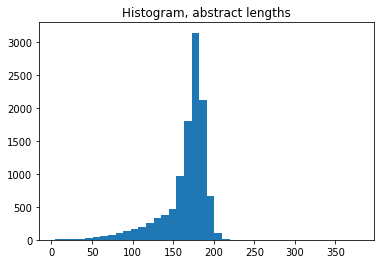

In [149]:
fig,ax= plt.subplots()

ax.hist(pd.Series([len(x) for x in abstract_corpus]),bins=40)

ax.set_title('Histogram, abstract lengths')

## 3. Word embeddings

In [150]:
#Identify 2-grams (frequent in science!)
bigram_transformer = gensim.models.Phrases(abstract_corpus)

In [151]:
#Train the model on the corpus

#Let's do a bit of grid search

#Window represents the window of words we use
window = [5,10,15]
#Minimum number of occurrences in the corpus
min_count = [2,5,10]

#Create the cartesian product of both parameters
grid_search = list(itertools.product(window,min_count))

#Container
w2v_mods = []

#Train
for num,x in enumerate(grid_search):
    print(num)
    
    #Train
    model = gensim.models.Word2Vec(bigram_transformer[abstract_corpus], size=360, window=x[0], min_count=x[1], iter=20)
    
    #Append to container
    w2v_mods.append((x,model))

0


/usr/local/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



1
2
3
4
5
6
7
8


In [152]:
#Words to check
word_checks = ['machine_learning','statistics','graphene','politics']

#Extract most similar words
some_checks = [[x[0],[[w,x[1].most_similar(w)] for w in word_checks]] for x in w2v_mods]

#The similar words make sense. But we still need to choose a model. Let's do what Kostas said. Compare
#Performance for 100 words?
some_checks

[[(5, 2),
  [['machine_learning',
    [('artificial_intelligence', 0.8544259071350098),
     ('data_mining', 0.8445111513137817),
     ('ai', 0.8379030227661133),
     ('image_processing', 0.8208881616592407),
     ('data_processing', 0.7834540605545044),
     ('data_analysis', 0.762863278388977),
     ('multi_modal', 0.755476713180542),
     ('computer_vision', 0.7548614740371704),
     ('data_fusion', 0.7495485544204712),
     ('signal_processing', 0.7494875192642212)]],
   ['statistics',
    [('descriptions', 0.7610723376274109),
     ('multivariate', 0.726506233215332),
     ('semantics', 0.7197113633155823),
     ('parsing', 0.7145382165908813),
     ('statistical', 0.7028642296791077),
     ('graph', 0.6924411058425903),
     ('statistical_methods', 0.6858022212982178),
     ('radiocarbon', 0.6797977685928345),
     ('graphs', 0.6767812967300415),
     ('computational_models', 0.667502760887146)]],
   ['graphene',
    [('semiconductors', 0.8380407094955444),
     ('nanowires', 0.

In [236]:
#We will choose 100 random words
from functools import reduce

#We need to find a shared vocabulary
#This list has the vocabulary for each model (nb some of the models have less words because
#we set different word counts for inclusion in the data)
vocab = [list(x[1].vocab.keys()) for x in w2v_mods]

print([len(x) for x in vocab])

#Reduce is a cool function - it applies the set function to two arguments in a sequence cumulatively 
shared_vocab = list(reduce(set.intersection, [set(item) for item in vocab ]))

#Picked 100 random words
random_words = [shared_vocab[x] for x in set(np.random.randint(0,len(shared_vocab),1000))]

[44681, 28797, 17813, 44681, 28797, 17813, 44681, 28797, 17813]


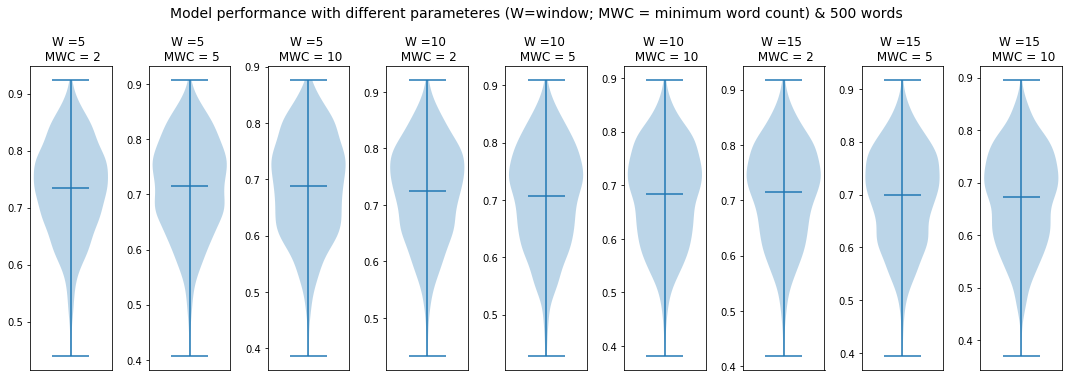

In [237]:
#We can visualise this a couple of ways.
#In one of them, we create a histogram with the mean scores for the most similar words.
#Models that tend to get higher similarities will be shifted to the right.

#The problem is that many of the words we are checking could be non-sense. 
#Do we produce a barplot with the 100 words? 

fig,ax = plt.subplots(ncols=len(w2v_mods),nrows=1,figsize=(15,5))


out = []

for num,x in enumerate(w2v_mods):
    
    #Extract the model
    model = x[1]
    
    #Extract the most similar words for each random word
    results = [model.most_similar(x) for x in random_words]
    
    #Extract the mean similarity for each result
    stats = [np.mean([x[1] for x in el]) for el in results]
    
    out.append(stats)
    
    #ax[num].hist(stats,bins=20)
    ax[num].violinplot(stats,showmeans=True)
    ax[num].set_title('W ={w} \n MWC = {m}'.format(w=x[0][0],m=x[0][1]))
    
    #Hide the ticks
    ax[num].set_xticks([])
    ax[num].set_xticklabels([])

#NB Use the y to determine where 
fig.suptitle('Model performance with different parameteres (W=window; MWC = minimum word count) & 500 words',
            size=14,y=1.05)

plt.tight_layout()

In [238]:
#The best model seems to be Number 2 [window= 5 words and minimum word count = 5 words]

w2v_mods[1][1].most_similar('machine_learning')

[('artificial_intelligence', 0.8653401136398315),
 ('ai', 0.8501592874526978),
 ('data_mining', 0.8295114040374756),
 ('image_processing', 0.7923502922058105),
 ('data_processing', 0.7570922374725342),
 ('signal_processing', 0.7529588341712952),
 ('computer_vision', 0.7486411333084106),
 ('data_fusion', 0.728797972202301),
 ('cad', 0.7244783639907837),
 ('data_analysis', 0.7238456606864929)]

In [239]:
w2v_mods[1][1].most_similar('statistics')

[('multivariate', 0.7360368967056274),
 ('descriptions', 0.7287214398384094),
 ('statistical', 0.7029473185539246),
 ('semantics', 0.6888142824172974),
 ('radiocarbon', 0.6709029674530029),
 ('multi_dimensional', 0.665830671787262),
 ('statistical_methods', 0.665817379951477),
 ('graph', 0.6656977534294128),
 ('arguments', 0.6611547470092773),
 ('graphs', 0.660990297794342)]

In [240]:
w2v_mods[1][1].most_similar('graphene')

[('semiconductors', 0.8089393377304077),
 ('nanowires', 0.8016127347946167),
 ('heterostructures', 0.7994060516357422),
 ('semiconducting', 0.7951947450637817),
 ('thin_films', 0.7897544503211975),
 ('conductors', 0.7853257656097412),
 ('layered_materials', 0.7848166823387146),
 ('electronic_properties', 0.7828670144081116),
 ('doped', 0.7809760570526123),
 ('field_effect', 0.7706782221794128)]

In [771]:
w2v_mods[1][1].most_similar('design')

[('optimization', 0.4733940362930298),
 ('designs', 0.4422915577888489),
 ('design_manufacturing', 0.43518638610839844),
 ('co_design', 0.4333535432815552),
 ('designing', 0.41841554641723633),
 ('optimisation', 0.4052669405937195),
 ('design_implementation', 0.40277183055877686),
 ('design_optimisation', 0.398322194814682),
 ('design_rules', 0.3973497748374939),
 ('verification_validation', 0.3748871982097626)]

In [243]:
#Save the model
w2v_mods[1][1].save('../models/best_w2v_model.word2vec')

## 3. TSNE analysis

In [247]:
# Instantiate TSNE class
w2v = w2v_mods[1][1]

#This extracts the TSNE representation of the word vectors.
ts = TransformerTSNE(w2v)

# Store tokens and their vectors
dict_keys, dict_values = ts.unravel_dictionary(ts.word_vectors())

# Calculate cosine distance
cos_dist = ts.calculate_cosine_distance(ts.calculate_cosine_similarity(ts.vectors2sparse_matrix(dict_values)))
print('SHAPE OF COSINE DISTANCE MATRIX: {}'.format(cos_dist.shape))


SHAPE OF COSINE DISTANCE MATRIX: (28797, 28797)


In [248]:
# Train TSNE with perplexity=90
tsne_space = ts.tsne_transformation(cos_dist, 10000, 90)

# Visualise TSNE
ts.word_vectors_in_space(dict_keys, tsne_space)

[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 28797
[t-SNE] Computed conditional probabilities for sample 2000 / 28797
[t-SNE] Computed conditional probabilities for sample 3000 / 28797
[t-SNE] Computed conditional probabilities for sample 4000 / 28797
[t-SNE] Computed conditional probabilities for sample 5000 / 28797
[t-SNE] Computed conditional probabilities for sample 6000 / 28797
[t-SNE] Computed conditional probabilities for sample 7000 / 28797
[t-SNE] Computed conditional probabilities for sample 8000 / 28797
[t-SNE] Computed conditional probabilities for sample 9000 / 28797
[t-SNE] Computed conditional probabilities for sample 10000 / 28797
[t-SNE] Computed conditional probabilities for sample 11000 / 28797
[t-SNE] Computed conditional probabilities for sample 12000 / 28797
[t-SNE] Computed conditional probabilities for sample 13000 / 28797
[t-SNE] Computed conditional probabilities for sample 14000 / 28797
[t-SNE] Comput

In [250]:
%%time

#Use another perplexity.
tsne_space_50p = ts.tsne_transformation(cos_dist, 10000, 50)

# Visualise TSNE
ts.word_vectors_in_space(dict_keys, tsne_space_50p)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 28797
[t-SNE] Computed conditional probabilities for sample 2000 / 28797
[t-SNE] Computed conditional probabilities for sample 3000 / 28797
[t-SNE] Computed conditional probabilities for sample 4000 / 28797
[t-SNE] Computed conditional probabilities for sample 5000 / 28797
[t-SNE] Computed conditional probabilities for sample 6000 / 28797
[t-SNE] Computed conditional probabilities for sample 7000 / 28797
[t-SNE] Computed conditional probabilities for sample 8000 / 28797
[t-SNE] Computed conditional probabilities for sample 9000 / 28797
[t-SNE] Computed conditional probabilities for sample 10000 / 28797
[t-SNE] Computed conditional probabilities for sample 11000 / 28797
[t-SNE] Computed conditional probabilities for sample 12000 / 28797
[t-SNE] Computed conditional probabilities for sample 13000 / 28797
[t-SNE] Computed conditional probabilities for sample 14000 / 28797
[t-SNE] Comput

# 4. Train and evaluate Gaussian mixtures

BEST GMM MODEL: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=28, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


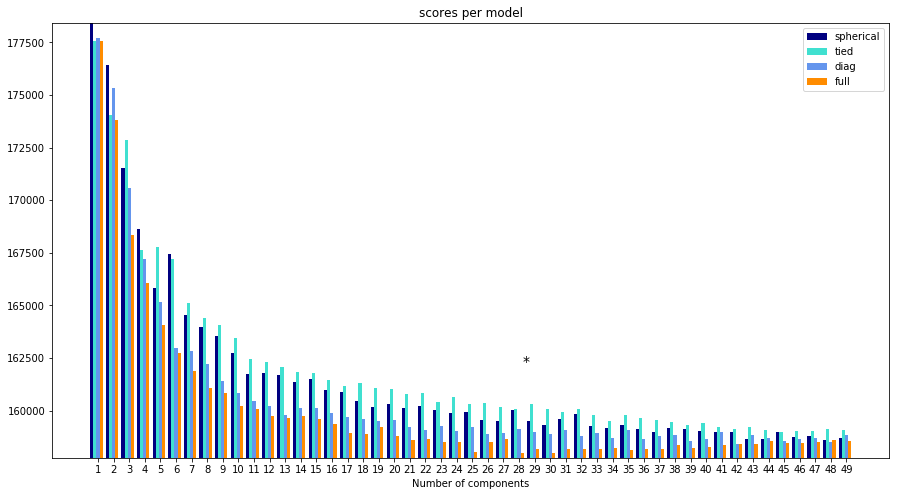

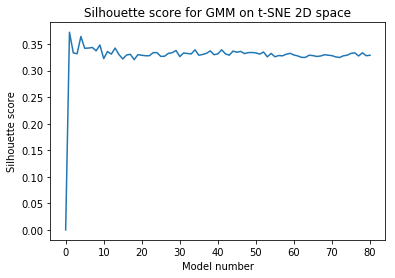

NameError: name 'tsne_space2' is not defined

In [251]:
# Instantiate the class using the 2D space from t-SNE
gmm_eval = GaussianMixtureEvaluation(tsne_space_50p)

best_gmm, bic = gmm_eval.bic_gmm()
print('BEST GMM MODEL: {}'.format(best_gmm))


# Instantiate class using the best gmm model
gmm_vis = VisualiseEvaluationGMM(best_gmm)

gmm_vis.bic_plot(bic)

# Use silhouette scores to evaluate gmm
best_gmm_model, scores = gmm_eval.calculate_silhouette_scores('full')


# The higher the better
gmm_vis.silhouette_plot(scores)

# Predict token clusters based on best_gmm
token_labels = best_gmm.predict(tsne_space_50p)

# Create a list of tuples: [(token, cluster)] that will be used to classify projects
clustered_tokens = [tuple((dict_keys[i], token_labels[i])) for i in range(len(dict_keys))]

def plot_gmm_clusters(gmm_clf, data):
    """Plot the 2D representation of tokens and colour them according to the GMM clusters."""
    labels = gmm_clf.predict(data)
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(12,12))
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)

        xy = data[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)

    plt.title('Estimated number of clusters: {0}'.format(gmm_clf.n_components))
    plt.show()

/usr/local/lib/python3.5/site-packages/matplotlib/lines.py:1206: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



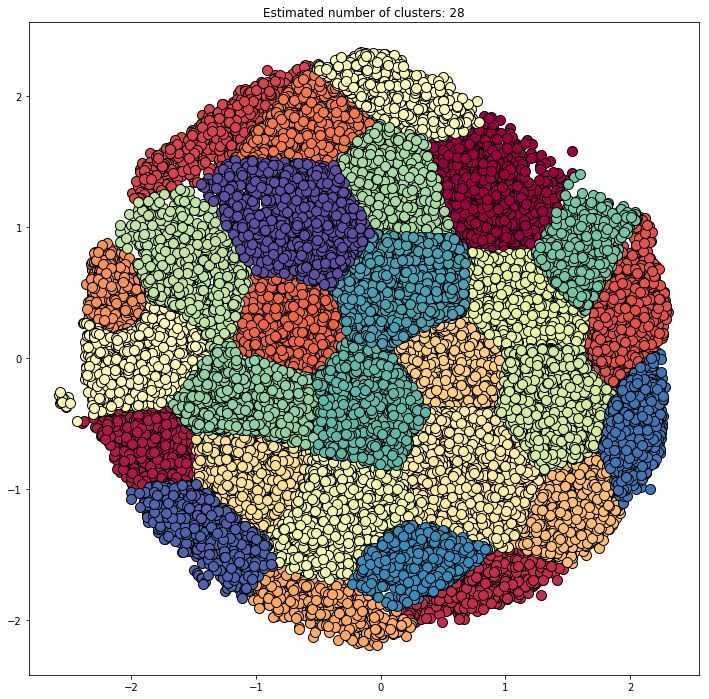

In [253]:
plot_gmm_clusters(best_gmm, tsne_space_50p)

In [616]:
# Ok. So what is in these clusters?

#Let's get the top words on each
#This dict contains the number of appearances for each token in the vocabulary
vocab_count = {x:w2v.vocab[x].count for x in list(w2v.vocab.keys())}

#With counts
clustered_tokens_counted = [(x)+(vocab_count[x[0]],) for x in clustered_tokens]

top_50_tokens_per_cluster=[]

#Now group and sort.

#NB 28 is the number of clusters in the data

for x in np.arange(len(set([x[1] for x in clustered_tokens]))):
    #Select the group and sort by count
    sorted_in_group = sorted([el for el in clustered_tokens_counted if el[1]==x],key=lambda x:x[2],reverse=True)
    
    #Select top 50
    top_50 = sorted_in_group[:50]
    
    #Check
    top_50_tokens_per_cluster.append([x,top_50])

top_50_tokens_per_cluster

[[0,
  [('development', 0, 5599),
   ('provide', 0, 3462),
   ('well', 0, 3224),
   ('europe', 0, 2823),
   ('design', 0, 2822),
   ('innovation', 0, 2342),
   ('support', 0, 2236),
   ('solution', 0, 1955),
   ('solutions', 0, 1804),
   ('order', 0, 1741),
   ('allow', 0, 1616),
   ('enable', 0, 1552),
   ('advanced', 0, 1526),
   ('focus', 0, 1337),
   ('providing', 0, 1272),
   ('proposed', 0, 1224),
   ('devices', 0, 1199),
   ('implementation', 0, 1175),
   ('health', 0, 1157),
   ('create', 0, 1128),
   ('structure', 0, 1101),
   ('companies', 0, 1095),
   ('state_art', 0, 1083),
   ('towards', 0, 1052),
   ('able', 0, 1025),
   ('via', 0, 993),
   ('make', 0, 993),
   ('structures', 0, 956),
   ('building', 0, 929),
   ('help', 0, 905),
   ('could', 0, 803),
   ('end', 0, 795),
   ('expected', 0, 791),
   ('would', 0, 784),
   ('generate', 0, 782),
   ('enabling', 0, 782),
   ('deliver', 0, 769),
   ('offer', 0, 767),
   ('provides', 0, 760),
   ('ability', 0, 736),
   ('opportu

The results aren't very enlightening. Many of the words we are picking up are quite generic

In [308]:
#What can we do to address this?

In [482]:
#Perhaps we could remove them before the clustering based on their average TF IDF score, and focus instead on 
#'spiky' distinctive words?

#Steps?

#Calculate the TFIDF for words in the transformed corpus

#Calculate the average TF IDF per word

#Corpus with bigrams
#corpus_w_bigrams = bigram_transformer[abstract_corpus]

#TF IDF vectoriser
tfidf = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False)

#TF IDF output
result_tfidf = tfidf.fit(abstract_corpus)

In [483]:
# Word mapping. Index of values in the vocabulary
value_index = result_tfidf.vocabulary_
f = [[v,k] for k, v in value_index.items()]
f_sorted = sorted(f,key=lambda x:x[0],reverse=False)

# Transform the original documents
transformed = tfidf.transform(corpus_w_bigrams)

/usr/local/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [484]:
#Transformed is a spare matrix where the rows are the documents and the columns are the values.
#Words with high mean tf idf tend to appear across the corpus; words with low mean tf idf are more 
#specific to 
tf_idf_means = [(x,y) for x,y in zip([x[1] for x in f_sorted],transformed.mean(axis=0).tolist()[0])]

#Here they are
sorted(tf_idf_means,key=lambda x:x[1],reverse=True)[:500]

[('project', 0.019145226974289397),
 ('research', 0.015915019892669788),
 ('new', 0.01540119640629372),
 ('based', 0.013471103956466194),
 ('development', 0.01346687524620014),
 ('system', 0.013147941015260178),
 ('technology', 0.012667738603670618),
 ('systems', 0.012206447022978602),
 ('market', 0.011707602524385088),
 ('data', 0.011669187659354726),
 ('european', 0.011139191396079872),
 ('also', 0.010655612793556646),
 ('use', 0.010294554479592528),
 ('energy', 0.00949267022083818),
 ('using', 0.009369159073370511),
 ('provide', 0.009244856783368177),
 ('process', 0.009208239972927737),
 ('novel', 0.009062482882601811),
 ('design', 0.008889055478442041),
 ('innovative', 0.008872777510524751),
 ('well', 0.008863471940441648),
 ('technologies', 0.00885456668873941),
 ('eu', 0.008503522664989074),
 ('innovation', 0.008455853484771712),
 ('applications', 0.00827438856370051),
 ('study', 0.008235190892895086),
 ('approach', 0.00821463767791235),
 ('europe', 0.00818599310525536),
 ('poten

In [485]:
#Let's remove the top ~500 and see what happens
sorted(tf_idf_means,key=lambda x:x[1],reverse=True)[450:550]

[('mobile', 0.0025358454192239265),
 ('enhanced', 0.002535275749361819),
 ('early', 0.002530836836393742),
 ('mobility', 0.002528958259850325),
 ('functions', 0.002523125045258484),
 ('require', 0.0025220529344872856),
 ('implement', 0.002520878687767447),
 ('already', 0.0025190390346905025),
 ('given', 0.002518931214115958),
 ('cooperation', 0.0025181662532386974),
 ('focused', 0.002517409125788867),
 ('exploit', 0.002510973858473349),
 ('still', 0.002510803438495795),
 ('urban', 0.002509557282234081),
 ('waste', 0.002508919957457609),
 ('plants', 0.0025069361870997185),
 ('strategic', 0.0025059255940172707),
 ('generation', 0.0024997574115685037),
 ('storage', 0.002487307940236955),
 ('flexible', 0.0024834208364045087),
 ('general', 0.0024814945759372513),
 ('made', 0.002481441286769279),
 ('creating', 0.002475907060912727),
 ('called', 0.00247206997847592),
 ('traditional', 0.002469317164146036),
 ('complexity', 0.002466314322568962),
 ('life', 0.0024659398929730847),
 ('climate', 0

In [493]:
#We'll work with 
#These are the tokens to drop
tokens_to_drop = [x[0] for x in sorted(tf_idf_means,key=lambda x:x[1],reverse=True)[:100]]

#This is the abstract corpus without generic words
abstract_corpus_edited = [[x for x in el if x not in set(tokens_to_drop)] for el in abstract_corpus]

#Phrase transformer
bigram_transformer_edited = gensim.models.Phrases(abstract_corpus_edited)


In [505]:
#New models?

#Train the model on the corpus

#Let's do a bit of grid search with the new corpus.
#This is repetitive. Could 

#Window represents the window of words we use
window = [5,10,15]
#Minimum number of occurrences in the corpus
min_count = [2,5,10]

#Create the cartesian product of both parameters
grid_search = list(itertools.product(window,min_count))

#Container
w2v_mods_edited = []

#Train
for num,x in enumerate(grid_search):
    print(num)
    
    #Train
    model = gensim.models.Word2Vec(bigram_transformer_edited[
        abstract_corpus_edited], size=360, window=x[0], min_count=x[1], iter=20)
    
    #Append to container
    w2v_mods_edited.append((x,model))

0


/usr/local/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



1
2
3
4
5
6
7
8


In [509]:
#Words to check
word_checks = ['machine_learning','statistics','graphene','politics']

#Extract most similar words
some_checks = [[x[0],[[w,x[1].most_similar(w)] for w in word_checks]] for x in w2v_mods_edited]

#The similar words make sense. But we still need to choose a model. Let's do what Kostas said. Compare
#Performance for 100 words?
some_checks

[[(5, 2),
  [['machine_learning',
    [('artificial_intelligence', 0.8761323690414429),
     ('algorithms', 0.8656830191612244),
     ('image_processing', 0.8645797371864319),
     ('ai', 0.8630869388580322),
     ('signal_processing', 0.8456432223320007),
     ('visualisation', 0.8387088775634766),
     ('computer_vision', 0.8251583576202393),
     ('algorithm', 0.8226801156997681),
     ('query', 0.8137627243995667),
     ('graphical', 0.8117427229881287)]],
   ['statistics',
    [('analytic', 0.8322955369949341),
     ('descriptions', 0.8291432857513428),
     ('graph', 0.7962055206298828),
     ('bayesian', 0.796005368232727),
     ('theoretic', 0.7913828492164612),
     ('semantics', 0.7887023687362671),
     ('explicit', 0.7804808616638184),
     ('statistical', 0.7799347639083862),
     ('abstract', 0.7743422985076904),
     ('graphs', 0.7696376442909241)]],
   ['graphene',
    [('heterostructures', 0.872240424156189),
     ('layered', 0.8676406145095825),
     ('thin_films', 0.

In [510]:
#We did this before. Repetitive! 

vocab_ed = [list(x[1].vocab.keys()) for x in w2v_mods_edited]

#print([len(x) for x in vocab])

#Reduce is a cool function - it applies the set function to two arguments in a sequence cumulatively 
shared_vocab_ed = list(reduce(set.intersection, [set(item) for item in vocab_ed]))

#Picked 100 random words
random_words = [shared_vocab_ed[x] for x in set(np.random.randint(0,len(shared_vocab_ed),1000))]

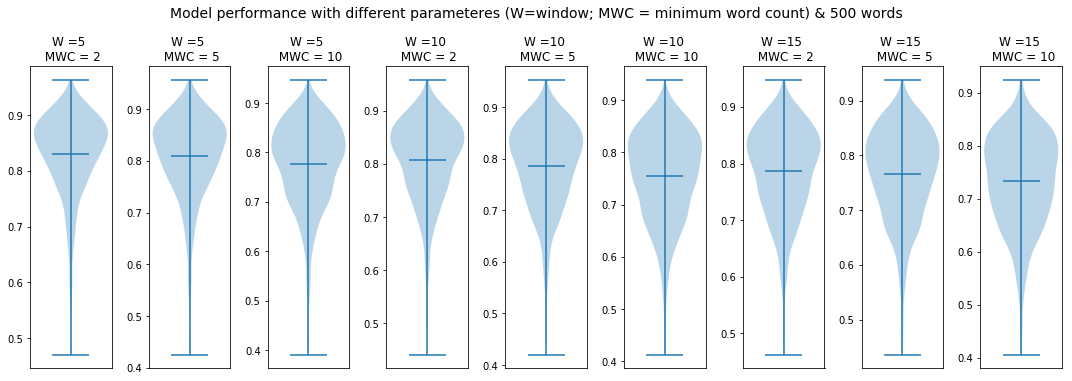

In [511]:
#We can visualise this a couple of ways.
#In one of them, we create a histogram with the mean scores for the most similar words.
#Models that tend to get higher similarities will be shifted to the right.

#The problem is that many of the words we are checking could be non-sense. 
#Do we produce a barplot with the 100 words? 

fig,ax = plt.subplots(ncols=len(w2v_mods),nrows=1,figsize=(15,5))


out = []

for num,x in enumerate(w2v_mods_edited):
    
    #Extract the model
    model = x[1]
    
    #Extract the most similar words for each random word
    results = [model.most_similar(x) for x in random_words]
    
    #Extract the mean similarity for each result
    stats = [np.mean([x[1] for x in el]) for el in results]
    
    out.append(stats)
    
    #ax[num].hist(stats,bins=20)
    ax[num].violinplot(stats,showmeans=True)
    ax[num].set_title('W ={w} \n MWC = {m}'.format(w=x[0][0],m=x[0][1]))
    
    #Hide the ticks
    ax[num].set_xticks([])
    ax[num].set_xticklabels([])

#NB Use the y to determine where 
fig.suptitle('Model performance with different parameteres (W=window; MWC = minimum word count) & 1000 words',
            size=14,y=1.05)

plt.tight_layout()

In [512]:
#These models perform much better than the ones with the stop words


#Let's re-do the TSNE analysis etc

# Instantiate TSNE class
w2v_edited = w2v_mods_edited[1][1]

#This extracts the TSNE representation of the word vectors.
ts_edited = TransformerTSNE(w2v_edited)

# Store tokens and their vectors
dict_keys, dict_values = ts_edited.unravel_dictionary(ts_edited.word_vectors())

# Calculate cosine distance
cos_dist = ts_edited.calculate_cosine_distance(ts_edited.calculate_cosine_similarity(
    ts_edited.vectors2sparse_matrix(dict_values)))
print('SHAPE OF COSINE DISTANCE MATRIX: {}'.format(cos_dist.shape))

SHAPE OF COSINE DISTANCE MATRIX: (27480, 27480)


In [515]:
#Use another perplexity.
tsne_space_50p_edited = ts_edited.tsne_transformation(cos_dist, 10000, 50)

# Visualise TSNE
ts_edited.word_vectors_in_space(dict_keys, tsne_space_50p_edited)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 27480
[t-SNE] Computed conditional probabilities for sample 2000 / 27480
[t-SNE] Computed conditional probabilities for sample 3000 / 27480
[t-SNE] Computed conditional probabilities for sample 4000 / 27480
[t-SNE] Computed conditional probabilities for sample 5000 / 27480
[t-SNE] Computed conditional probabilities for sample 6000 / 27480
[t-SNE] Computed conditional probabilities for sample 7000 / 27480
[t-SNE] Computed conditional probabilities for sample 8000 / 27480
[t-SNE] Computed conditional probabilities for sample 9000 / 27480
[t-SNE] Computed conditional probabilities for sample 10000 / 27480
[t-SNE] Computed conditional probabilities for sample 11000 / 27480
[t-SNE] Computed conditional probabilities for sample 12000 / 27480
[t-SNE] Computed conditional probabilities for sample 13000 / 27480
[t-SNE] Computed conditional probabilities for sample 14000 / 27480
[t-SNE] Comput

BEST GMM MODEL: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=28, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


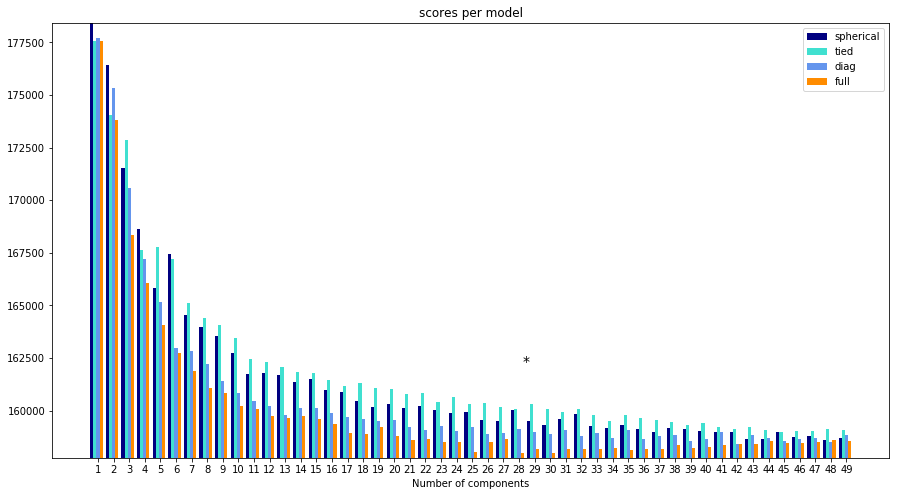

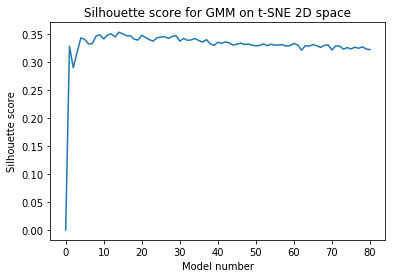

In [614]:
#Still need to run this
# Instantiate the class using the 2D space from t-SNE
gmm_eval_edited = GaussianMixtureEvaluation(tsne_space_50p_edited)

best_gmm_edited, bic_edited = gmm_eval_edited.bic_gmm()
print('BEST GMM MODEL: {}'.format(best_gmm))


# Instantiate class using the best gmm model
gmm_vis_edited = VisualiseEvaluationGMM(best_gmm_edited)

gmm_vis_edited.bic_plot(bic)

# Use silhouette scores to evaluate gmm
best_gmm_model_edited, scores_edited = gmm_eval_edited.calculate_silhouette_scores('full')


# The higher the better
gmm_vis_edited.silhouette_plot(scores_edited)

# Predict token clusters based on best_gmm
token_labels_edited = best_gmm_edited.predict(tsne_space_50p_edited)

# Create a list of tuples: [(token, cluster)] that will be used to classify Meetup groups
clustered_tokens_edited = [tuple((dict_keys[i], token_labels_edited[i])) for i in range(len(dict_keys))]

/usr/local/lib/python3.5/site-packages/matplotlib/lines.py:1206: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



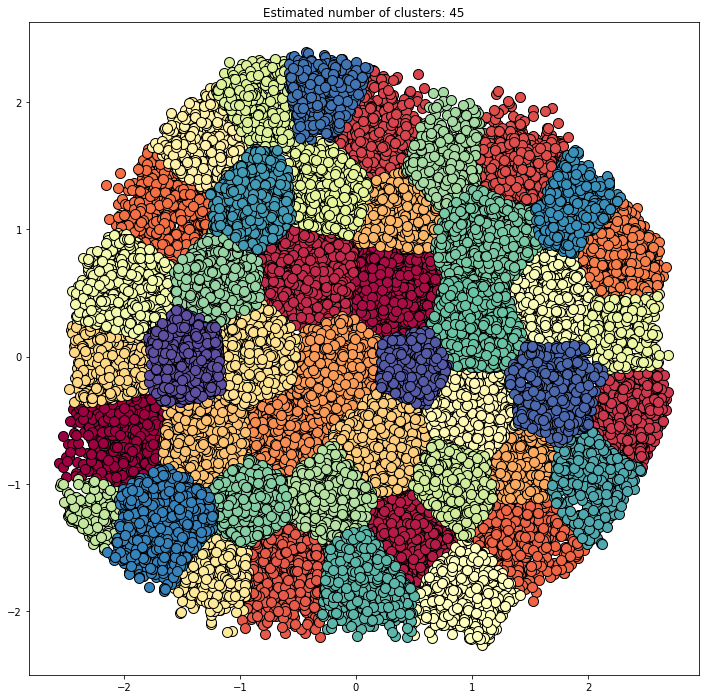

In [615]:
plot_gmm_clusters(best_gmm_edited, tsne_space_50p_edited)

In [623]:
# Ok. So what is in these clusters?

#Let's get the top words on each
#This dict contains the number of appearances for each token in the vocabulary
vocab_count_edited = {x:w2v_edited.vocab[x].count for x in list(w2v_edited.vocab.keys())}

#With counts
clustered_tokens_counted_edited = [(x)+(vocab_count_edited[x[0]],) for x in clustered_tokens_edited]

top_50_tokens_per_cluster_edited=[]

#Now group and sort.

#NB 28 is the number of clusters in the data

for x in np.arange(len(set([x[1] for x in clustered_tokens_counted_edited]))):
    #Select the group and sort by count
    sorted_in_group = sorted([el for el in clustered_tokens_counted_edited if el[1]==x],key=lambda x:x[2],reverse=True)
    
    #Select top 50
    top_50 = sorted_in_group[:50]
    
    #Check
    top_50_tokens_per_cluster_edited.append([x,top_50])
    
top_50_tokens_per_cluster_edited

[[0,
  [('quality', 0, 1508),
   ('cost', 0, 1205),
   ('like', 0, 1018),
   ('costs', 0, 999),
   ('would', 0, 873),
   ('expected', 0, 863),
   ('become', 0, 774),
   ('value', 0, 679),
   ('etc', 0, 618),
   ('opportunity', 0, 590),
   ('less', 0, 532),
   ('consumption', 0, 513),
   ('alternative', 0, 412),
   ('emissions', 0, 387),
   ('makes', 0, 348),
   ('sales', 0, 289),
   ('consumer', 0, 288),
   ('savings', 0, 286),
   ('consumers', 0, 278),
   ('home', 0, 268),
   ('concrete', 0, 268),
   ('price', 0, 255),
   ('productivity', 0, 252),
   ('value_chain', 0, 239),
   ('maintain', 0, 238),
   ('get', 0, 236),
   ('reaching', 0, 217),
   ('added_value', 0, 207),
   ('points', 0, 205),
   ('saving', 0, 203),
   ('losses', 0, 198),
   ('farmers', 0, 192),
   ('life_cycle', 0, 184),
   ('becoming', 0, 179),
   ('regulations', 0, 175),
   ('producers', 0, 171),
   ('costly', 0, 169),
   ('segments', 0, 168),
   ('continue', 0, 165),
   ('segment', 0, 164),
   ('maintaining', 0, 1

## And what about LDA?

Although the quality of the clusters has improved in the second iteration, they are still difficult to interpret and in some cases
not very don't appear to be very robust. 

We will try a different approach using LDA,a model that looks for the combinations of topics (i.e. linear combinations of words) most likely to generate the documents in the corpus


In [580]:
#Stages

#We have some options here: num_topics and TFIDF

#This creates combinations of possible parameters for our grid search
lda_params = list(product([50,100,150,200,250,300],[True,False]))

#Create a dictionary that maps words to ids
dictionary = gensim.corpora.Dictionary(bigram_transformer[abstract_corpus])

#Create a bag of words with the ids
corpus_bow = [dictionary.doc2bow(x) for x in bigram_transformer[abstract_corpus]]

#Initialise a tfids model
tf_idf = gensim.models.TfidfModel(corpus_bow)

#Tfidfd corpus
tf_idf_corpus = tf_idf[corpus_bow]

#LDA model container
lda_models = []

#Loop that trains the models and appends them to the lda_models container. We can use this to decide which
#is the best model

for x in lda_params:
    #Print stage
    print('{x}_{y}'.format(x=x[0],y=x[1]))
    
    if x[1]==True:
        mod = gensim.models.LdaModel(tf_idf_corpus,num_topics=x[0],id2word=dictionary,
                                    passes=10,iterations=100)
    else:
        mod = gensim.models.LdaModel(corpus_bow,num_topics=x[0],id2word=dictionary,
                                    passes=10,iterations=100)
    
    lda_models.append([x,mod])


/usr/local/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



50_True
50_False
100_True
100_False
150_True
150_False
200_True
200_False
250_True
250_False
300_True
300_False


In [591]:
#Let's measure topic coherence for these.
from gensim.models.coherencemodel import CoherenceModel

#Extract topic coherences
coherence_models = [CoherenceModel(model=x[1],
                             texts=bigram_transformer[abstract_corpus],
                             dictionary=dictionary,coherence='c_v') for x in lda_models]


coherence_values = [(pars,x.get_coherence()) for pars,x in zip(lda_params,coherence_models)]


/usr/local/lib/python3.5/site-packages/gensim/models/phrases.py:248: UserWarning:

For a faster implementation, use the gensim.models.phrases.Phraser class



In [592]:
#This suggests that the best model is the one with 150 topics and no normalisation via TFIDF
coherence_values

[((50, True), 0.48943325223918976),
 ((50, False), 0.55674247839401148),
 ((100, True), 0.44527003171334284),
 ((100, False), 0.49715896093039447),
 ((150, True), 0.43258671391904546),
 ((150, False), 0.47582506507199529),
 ((200, True), 0.41980942921214703),
 ((200, False), 0.45561301138938187),
 ((250, True), 0.39858691409548019),
 ((250, False), 0.45543272155714604),
 ((300, True), 0.38532395266020647),
 ((300, False), 0.44270489771785682)]

In [601]:
lda_models[3][1].show_topics(num_topics=100)

[(0,
  '0.046*"sensor" + 0.045*"sensors" + 0.026*"sensing" + 0.016*"detection" + 0.014*"magnetic" + 0.013*"grant" + 0.010*"proof_concept" + 0.010*"monitoring" + 0.009*"measurement" + 0.009*"man"'),
 (1,
  '0.015*"physics" + 0.013*"new" + 0.012*"observations" + 0.010*"mass" + 0.010*"energy" + 0.010*"solar" + 0.009*"models" + 0.008*"evolution" + 0.008*"simulations" + 0.008*"data"'),
 (2,
  '0.014*"uncertainty" + 0.013*"time" + 0.011*"economics" + 0.010*"data" + 0.008*"decision" + 0.007*"analysis" + 0.007*"stochastic" + 0.006*"optimal" + 0.006*"decisions" + 0.005*"smart_cities"'),
 (3,
  '0.069*"space" + 0.017*"maintenance" + 0.014*"rail" + 0.013*"railway" + 0.013*"train" + 0.010*"satellites" + 0.010*"track" + 0.009*"generator" + 0.009*"cryptography" + 0.008*"orbit"'),
 (4,
  '0.023*"iot" + 0.022*"technologies" + 0.012*"industrial" + 0.012*"industry" + 0.011*"development" + 0.009*"mining" + 0.009*"fiware" + 0.008*"design" + 0.008*"innovative" + 0.006*"technology"'),
 (5,
  '0.011*"african

In [611]:
#Save model
with open(model_path+'/lda_models.p','wb') as outfile:
    pickle.dump(lda_models[3],outfile)

In [ ]:
#Exploration of topics via LDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [613]:
pyLDAvis.gensim.prepare(lda_models[3][1], corpus_bow, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
56     5.188751        1       1 -0.245893 -0.090221
72     4.093668        1       2 -0.244348 -0.063395
85     3.612188        1       3 -0.204260  0.011984
77     3.505642        1       4 -0.188598 -0.165237
7      3.400690        1       5 -0.206350 -0.071056
70     3.187162        1       6 -0.193135  0.129381
24     3.117242        1       7 -0.232358 -0.170500
59     3.049112        1       8 -0.220351 -0.020465
79     2.505844        1       9 -0.212798 -0.074663
63     2.447271        1      10 -0.187612  0.123365
48     2.378959        1      11 -0.158479 -0.034879
64     2.231661        1      12 -0.150640  0.216268
62     2.158405        1      13 -0.161204  0.154328
25     2.097716        1      14 -0.179170 -0.067316
69     1.952583        1      15 -0.123204  0.199953
61     1.927479        1      16 -0.177790 -0.108308
38     1.901481        1      17 -0.130729  0.137691
39     1.818781        1      18 -0.139826  0.090522
54     1.589001        1      19 -0.117136  0.204645
26     1.505275        1      20 -0.147394  0.018086
53     1.487286        1      21 -0.167899 -0.042230
44     1.461878        1      22 -0.133590 -0.178699
60     1.461594        1      23 -0.111295 -0.091067
43     1.375638        1      24 -0.099525 -0.106744
65     1.319402        1      25 -0.120617  0.143935
87     1.162265        1      26 -0.107148 -0.012469
55     1.100453        1      27 -0.098190  0.037039
34     1.037424        1      28 -0.077846 -0.008161
1      1.029525        1      29 -0.095950  0.100081
74     1.005464        1      30 -0.047966  0.141690
...         ...      ...     ...       ...       ...
22     0.392803        1      71  0.070395 -0.007383
57     0.391819        1      72  0.090346  0.056548
58     0.381595        1      73  0.095278 -0.001064
88     0.373038        1      74  0.108216  0.023474
92     0.367609        1      75  0.128154 -0.043821
31     0.367005        1      76  0.096736 -0.038742
97     0.366794        1      77  0.108859  0.042463
11     0.361473        1      78  0.128130 -0.021450
52     0.351847        1      79  0.132313  0.020176
35     0.348675        1      80  0.113512  0.020448
68     0.346498        1      81  0.105184 -0.037661
49     0.324207        1      82  0.138433 -0.048934
33     0.323076        1      83  0.129286 -0.032249
67     0.322433        1      84  0.139999 -0.017235
47     0.319776        1      85  0.142377  0.005663
12     0.317469        1      86  0.115428 -0.027148
20     0.304118        1      87  0.153065 -0.023937
37     0.300873        1      88  0.124424  0.029518
95     0.300751        1      89  0.150281  0.002204
10     0.299749        1      90  0.142531  0.023824
29     0.294467        1      91  0.124845 -0.030166
76     0.293477        1      92  0.142175 -0.005831
83     0.288828        1      93  0.147619 -0.019248
99     0.282208        1      94  0.168506  0.007995
6      0.271018        1      95  0.134474  0.015230
40     0.268608        1      96  0.149702 -0.024716
71     0.268499        1      97  0.160284 -0.023557
9      0.255132        1      98  0.167914 -0.013398
27     0.254280        1      99  0.174665 -0.005931
16     0.249788        1     100  0.168172 -0.029266

[100 rows x 5 columns], topic_info=       Category          Freq                       Term         Total  \
term                                                                     
19879   Default   4117.000000                     market   4117.000000   
16221   Default   3965.000000                       data   3965.000000   
19577   Default   6934.000000                   research   6934.000000   
42977   Default   2242.000000                 innovation   2242.000000   
22627   Default   2692.000000                     energy   2692.000000   
47797   Default   2039.000000                  materials   2039.000000   
31

In [681]:
#Now we want to cluster these topics into a smaller set. This will reduce noise in the data and simplify communication of findings
selected_model = lda_models[3][1]

#Predict the topics
docs_topics = selected_model[corpus_bow]

#Create labels
#Extract labels
word_distributions = selected_model.show_topics(num_topics=100)
    
#This is splitting by the '"' and then getting the first 8 keywords, to read the topics.
labs = ["_".join(list(np.array(x[1].split('"'))[[1,3,5,7,9,11,13,15]])) for x in word_distributions]

#Convert to document-term matrix
doc_term_df = pd.DataFrame([{x[0]:x[1] for x in el} for el in docs_topics])

#Relabel columns
doc_term_df.columns=labs

In [682]:
#NAs are zeros

doc_term_df.fillna(0,inplace=True)

In [701]:
#Create distance matrix between topics
from sklearn.metrics.pairwise import cosine_similarity

#Distances
topic_cosine_similarities = cosine_similarity(np.array(doc_term_df.T))

topic_cosine_sim_df = pd.DataFrame(topic_cosine_similarities,index=labs,columns=labs)

#Some eyeballing suggests this is looking good.
topic_cosine_sim_df.to_csv(interim_path+'/similarity_matrix.csv')

In [697]:
#Let's cluster them using some of Kostas' code
from sklearn import mixture

In [755]:
#Estimate number of clusters for different numbers of components.
#The number of clusters doesn't seem to be very stable so we'll do it 50 times, calculate the mean silouhette score and
#then estimate the number of clusters for that value.

#We will assign to each key (which represents the number of clusters) a silouhette score
score_dict={x:[] for x in np.arange(90)}

count = 0

while count<50:
    if count%10==0:
        print(count)
    count += 1
        
    for i in range(10, 90):
        #print(i)
        gaussian = sklearn.mixture.GaussianMixture(n_components=i, covariance_type='full')
        gmm = gaussian.fit(topic_cosine_similarities)
        label = gmm.predict(topic_cosine_similarities)
        sil_score = metrics.silhouette_score(topic_cosine_similarities, label)
        score_dict[i].append(sil_score)

0
10
20
30
40


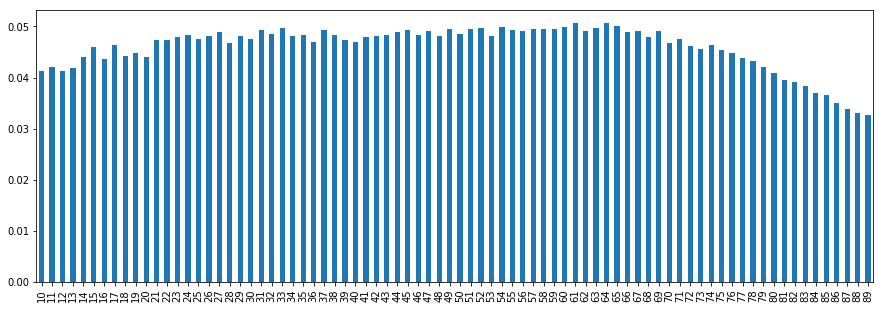

In [779]:
#Best score has X components

score_dict_set = {x:y for x,y in score_dict.items() if len(y)>0}

#Scores

cluster_size_mean = pd.DataFrame(score_dict_set).mean()

fig,ax = plt.subplots(figsize=(15,5))

cluster_size_mean.plot.bar(ax=ax)

#Maximum seems ~60.
#maximum_silouhette = scores.index(max(scores))

In [797]:
#Create a lookup for re-labelling and checking clusters. They seem to be quite stable
#We'll go for 40. NB I have set a random state to make the results reproducible.

#Initialise
best_gaussian = sklearn.mixture.GaussianMixture(n_components=40, covariance_type='full',random_state=782017)

#Fit
best_fit_gmm = best_gaussian.fit(topic_cosine_similarities)

#Predict
cluster_labels = best_fit_gmm.predict(topic_cosine_similarities)

#We will use this clusters lookup to relabel the clusters
cluster_label_lu = {num:x for num,x in enumerate(labs)}

labeled_clusters_sorted = sorted([(cluster_label_lu[num],x) for num,x in enumerate(cluster_labels)],key=lambda x: x[1])

In [800]:
#Labelled by hand, includes topics to drop because they didn't make sense or were mixed

cluster_lookup = {
    0:'tc_bio_chemistry',
    1:'tc_computational_methods',
    2:'tc_culture_development',
    3:'tc_industrial_internet',
    4:'tc_manufacturing_process_efficiency',
    5:'tc_medical',
    6:'tc_genetics',
    7:'tc_materials',
    8:'tc_aircraft',
    9:'tc_generic_terminology',
    10:'tc_climate_marine',
    11:'tc_biology_evolutionary',
    12:'drop',
    13:'tc_transport',
    14:'drop',
    15:'tc_data',
    16:'tc_infrastructure',
    17:'tc_generic_academic_activities',
    18:'tc_smes',
    19:'drop',
    20:'tc_energy',
    21:'drop',
    22:'tc_history',
    23:'tc_energy',
    24:'tc_social_policy',
    25:'tc_soil',
    26:'tc_recycling',
    27:'drop',
    28:'tc_heritage',
    29:'tc_nanotech',
    30:'tc_neuroscience_cognitive_science',
    31:'drop',
    32:'drop',
    33:'tc_robotics',
    34:'drop',
    35:'drop',
    36:'tc_health_tech',
    37:'drop',
    38:'drop',
    39:'drop'
}

In [828]:
#Sweet one-liner to merge topics
lda_topic_cluster_lookup = pd.DataFrame(cluster_lookup,index=['name']).T.join(pd.DataFrame(labeled_clusters_sorted).set_index(1))
lda_topic_cluster_lookup.columns=['cluster_topic','lda_topic']

#Combine with the topic df
doc_term_df_long = pd.melt(doc_term_df.reset_index(drop=False),id_vars='index')

doc_cluster_df = pd.pivot_table(pd.merge(
    doc_term_df_long,lda_topic_cluster_lookup,left_on='variable',right_on='lda_topic'),index='index',columns='cluster_topic',
                                values='value',
                                aggfunc=sum)

doc_cluster_final = doc_cluster_df.drop('drop',axis=1)

doc_cluster_final.to_csv(interim_path+'/project_cluster.csv')
